# OCO2 and TCCON Data Processing Using PySpark

- TCCON: http://www.tccon.caltech.edu/
- OCO2: https://ocov2.jpl.nasa.gov/

> We have extracted features as parquet files from oco2 hdf5 dataset. <br> 
We will cross-match these oco2 data with tccon measurements to create a training sample for ML. 

## Import Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py
#from netCDF4 import Dataset
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pq

from functools import reduce
import operator
import gc

In [2]:
# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

## Define SparkSession and sparkContext

In [3]:
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W


spark = SparkSession.builder \
    .master("yarn") \
    .appName("spark-shell") \
    .config("spark.driver.maxResultSize", "32g") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "14g") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.instances", "50") \
    .getOrCreate()


sc = spark.sparkContext
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [4]:
sc.getConf().getAll()[:10]

[('spark.driver.port', '44745'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_URI_BASES',
  'http://spark03:8088/proxy/application_1691388031001_1540'),
 ('spark.driver.memory', '32g'),
 ('spark.driver.appUIAddress', 'http://spark00:4040'),
 ('spark.app.id', 'application_1691388031001_1540'),
 ('spark.driver.maxResultSize', '32g'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'spark03'),
 ('spark.master', 'yarn'),
 ('spark.executor.id', 'driver'),
 ('spark.app.startTime', '1692174695200')]

## [1] Read All Parquets 

In [5]:
import pyarrow as pa
import pyarrow.parquet as pq

#### L1 Data

In [6]:
filepath = \
"hdfs://spark00:54310/user/ebkim/data/parquet/oco2/"

In [7]:
%%time
# Read all parquets in the directory
onedf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(filepath)

CPU times: user 1.04 ms, sys: 1.34 ms, total: 2.38 ms
Wall time: 3.87 s


> The total size of L1 dataset is 479.1 GB of the oco2 measurements in July 2021 

#### L2 Data

In [8]:
filepath2 = \
"hdfs://spark00:54310/user/ebkim/data/parquet/oco2L2/"

In [9]:
%%time
# Read all parquets in the directory
twodf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(filepath2)

CPU times: user 1.24 ms, sys: 0 ns, total: 1.24 ms
Wall time: 1.56 s


> The total size of L2 dataset is 296.9 MB of the oco2 measurements in July 2021

## [2] Explore the data

#### L1 Schema

In [10]:
onedf.printSchema()

root
 |-- filename: string (nullable = true)
 |-- channel_ind: integer (nullable = true)
 |-- pix_ind: integer (nullable = true)
 |-- row_ind: integer (nullable = true)
 |-- altitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- aspect: float (nullable = true)
 |-- slope: float (nullable = true)
 |-- sol_az: float (nullable = true)
 |-- sol_zn: float (nullable = true)
 |-- fo_az: float (nullable = true)
 |-- fo_zn: float (nullable = true)
 |-- flag: integer (nullable = true)
 |-- snr: float (nullable = true)
 |-- continuum: float (nullable = true)
 |-- time_str: string (nullable = true)
 |-- spectrum: array (nullable = true)
 |    |-- element: double (containsNull = true)



#### L2 Schema

In [11]:
twodf.printSchema()

root
 |-- filename: string (nullable = true)
 |-- altitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- aspect: float (nullable = true)
 |-- slope: float (nullable = true)
 |-- sol_az: float (nullable = true)
 |-- sol_zn: float (nullable = true)
 |-- xco2: float (nullable = true)
 |-- time_str: string (nullable = true)



In [12]:
someonecolumns = onedf.columns[4:11]+onedf.columns[16:18]
print(someonecolumns)

['altitude', 'longitude', 'latitude', 'aspect', 'slope', 'sol_az', 'sol_zn', 'time_str', 'spectrum']


In [13]:
onedf.select(someonecolumns).show(3,truncate=True)

+--------+----------+----------+------+-----+---------+--------+--------------------+--------------------+
|altitude| longitude|  latitude|aspect|slope|   sol_az|  sol_zn|            time_str|            spectrum|
+--------+----------+----------+------+-----+---------+--------+--------------------+--------------------+
|     0.0|-177.65903|-42.282303|   0.0|  0.0|331.95813|65.62309|2021-07-30T01:44:...|[5.05549377147219...|
|     0.0|-177.65883|-42.281914|   0.0|  0.0| 331.9579|65.62281|2021-07-30T01:44:...|[1.31257850944364...|
|     0.0| -177.6857|  -42.2795|   0.0|  0.0|331.98328|65.61138|2021-07-30T01:44:...|[1.27880160019929...|
+--------+----------+----------+------+-----+---------+--------+--------------------+--------------------+
only showing top 3 rows



In [14]:
sometwocolumns = twodf.columns[1:]
print(sometwocolumns)

['altitude', 'longitude', 'latitude', 'aspect', 'slope', 'sol_az', 'sol_zn', 'xco2', 'time_str']


In [15]:
twodf.select(sometwocolumns).show(3,truncate=True)

+--------+---------+----------+------+-----+---------+---------+------------+--------------------+
|altitude|longitude|  latitude|aspect|slope|   sol_az|   sol_zn|        xco2|            time_str|
+--------+---------+----------+------+-----+---------+---------+------------+--------------------+
|     0.0|117.99623|-1.8841984|   0.0|  0.0|316.61044|29.744112|4.1165485E-4|2021-07-26T05:39:...|
|     0.0|117.98365|-1.8850902|   0.0|  0.0|316.62778|  29.7362|4.1204828E-4|2021-07-26T05:39:...|
|     0.0|117.97101|-1.8858954|   0.0|  0.0|316.64508|29.728186| 4.119231E-4|2021-07-26T05:39:...|
+--------+---------+----------+------+-----+---------+---------+------------+--------------------+
only showing top 3 rows



### Basic Statistics 

In [16]:
%%time
twodf.select(sometwocolumns[:-1]).describe().toPandas().set_index('summary').transpose()

CPU times: user 10.4 ms, sys: 5.82 ms, total: 16.2 ms
Wall time: 29.5 s


summary,count,mean,stddev,min,max
altitude,6530842,272.9433890151779,622.3034413667915,-224.79272,6792.5073
longitude,6530842,-4.8765936931023965,108.90345186918307,-179.99997,179.99992
latitude,6530842,14.566058641889837,31.896905134055768,-57.848034,81.86451
aspect,6530842,67.23092611751224,107.41192521026139,0.0,359.99988
slope,6530842,1.2966478649836417,5.857427037034664,0.0,90.04166
sol_az,6530842,270.6378680925028,59.2007687958583,38.420395,333.3136
sol_zn,6530842,34.44357487660235,15.084898784866759,15.277826,84.99502
xco2,6530842,4.1110054904717444E-4,3.987470694656134E-6,1.7959013E-4,5.2126375E-4


In [17]:
%%time
onedf.select(someonecolumns[:-2]).describe().toPandas().set_index('summary').transpose()

CPU times: user 12 ms, sys: 4.79 ms, total: 16.8 ms
Wall time: 1min 46s


summary,count,mean,stddev,min,max
altitude,86406624,-4653.700015839513,69536.32245063811,-999999.0,6954.7114
longitude,86406624,3.8105722605718344,105.49336567673787,-180.0,180.0
latitude,86406624,20.359452069239005,43.51332991006797,-61.629215,81.86876
aspect,86406624,-5622.21574782042,75107.59495654641,-999999.0,360.0
slope,86406624,-5671.792578207138,75103.7884986975,-999999.0,90.18926
sol_az,86406624,243.85604549628556,596.049239835914,-999999.0,333.31796
sol_zn,86406624,45.291336605170414,589.6221873922492,-999999.0,89.68484


> **28** millions `L1` spectra and **6.5** millions `L2` $X_{co2}$ from the oco2 satellite in July 2021.

## [3] HealPix Partitioning (or GroupBy Healpix Index)

- healpy: https://healpy.readthedocs.io/en/latest/tutorial.html 

In [18]:
import healpy as hp

In [19]:
NSIDE = 512
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

3145728


> For $NSIDE = 512$, each healpix pixel size is 162 $km^2$ ($\approx 12.7 km \times 12.7 km$). 

In [20]:
NSIDE = 1024
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

12582912


> The total surface area of Earth is 509,600,000 $km^2$. <br> Hence, the area for each HealPix pixel (or, tile) is roughly 40 $km^2$ ($\approx 6.3 km \times 6.3 km$) for $NSIDE=1024$ 

### PySpark UDF for assigning healpix indices (`NSIDE = 1024`)

In [21]:
import numpy as np
import healpy as hp
def getHealPixIndexLatLon(inlat, inlon, nside):
    lat_theta = 0.5*np.pi - np.radians(inlat)
    lon_phi = np.radians(inlon)
    
    return int(hp.ang2pix(nside,theta = lat_theta,phi= lon_phi,nest=True))

In [22]:
getHealPixIndexLatLon(0,270,NSIDE)

7776938

In [23]:
hp.ang2pix(NSIDE,theta=np.pi*0.5,phi =np.pi*1.5, nest=True)

7776938

In [24]:
from functools import partial
healpix512udf = F.udf(partial(getHealPixIndexLatLon,nside=512),T.IntegerType())
healpix1024udf = F.udf(partial(getHealPixIndexLatLon,nside=1024),T.IntegerType())

In [25]:
#rawdf = rawdf.withColumn('ipx512nested',healpix512udf(F.col('latitude'),F.col('longitude')))

In [26]:
onedf = onedf.withColumn('ipx1024nested',healpix1024udf(F.col('latitude'),F.col('longitude')))
twodf = twodf.withColumn('ipx1024nested',healpix1024udf(F.col('latitude'),F.col('longitude')))

In [27]:
onedf.cache()

DataFrame[filename: string, channel_ind: int, pix_ind: int, row_ind: int, altitude: float, longitude: float, latitude: float, aspect: float, slope: float, sol_az: float, sol_zn: float, fo_az: float, fo_zn: float, flag: int, snr: float, continuum: float, time_str: string, spectrum: array<double>, ipx1024nested: int]

In [28]:
twodf.cache()

DataFrame[filename: string, altitude: float, longitude: float, latitude: float, aspect: float, slope: float, sol_az: float, sol_zn: float, xco2: float, time_str: string, ipx1024nested: int]

### GroupBy  `ipx1024nested` 

In [29]:
# Make sure the NSIDE value correct
NSIDE = 1024
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

12582912


In [30]:
%%time
onecountdf = onedf.groupBy('ipx1024nested').agg(F.count("*").alias("count"))
twocountdf = twodf.groupBy('ipx1024nested').agg(F.count("*").alias("count"))

CPU times: user 1.75 ms, sys: 0 ns, total: 1.75 ms
Wall time: 15.3 ms


In [31]:
full_index = pd.RangeIndex(start=0, stop=NPIX)

In [32]:
%%time
twovispdf = \
twocountdf.orderBy('ipx1024nested').toPandas()\
.set_index('ipx1024nested').reindex(full_index, fill_value=0)

CPU times: user 289 ms, sys: 71.7 ms, total: 360 ms
Wall time: 19.3 s


In [33]:
%%time
onevispdf = \
onecountdf.orderBy('ipx1024nested').toPandas()\
.set_index('ipx1024nested').reindex(full_index, fill_value=0)

CPU times: user 601 ms, sys: 237 ms, total: 838 ms
Wall time: 12min 10s


In [34]:
onevispdf.describe()

,count
count,1.258291e+07
mean,6.866982e+00
std,2.133843e+01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,3.436000e+03


In [35]:
twovispdf.describe()

,count
count,1.258291e+07
mean,5.190247e-01
std,3.164071e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.294000e+03


### TCCON Sites

In [36]:
tcconsites = [['Anmyeondo,Korea',126.3311,36.5382],['Caltech,USA',-118.1269,34.1362],
             ['Paris,France',2.356,48.846],['Sodankyla,Finland',26.6310,67.3668]]

In [37]:
tccondf = pd.DataFrame(tcconsites,columns=['location','lon','lat'])

In [38]:
tccondf.head()

,location,lon,lat
0,"Anmyeondo,Korea",126.3311,36.5382
1,"Caltech,USA",-118.1269,34.1362
2,"Paris,France",2.3560,48.8460
3,"Sodankyla,Finland",26.6310,67.3668


In [39]:
numtccon = len(tccondf.index)
numtccon

4

In [40]:
tcconphi = tccondf.lon.values * np.pi / 180.0
tccontheta = (90.0 - tccondf.lat.values) * np.pi / 180.0

In [41]:
tccontheta,tcconphi

(array([0.93308443, 0.97500724, 0.7182728 , 0.39502386]),
 array([ 2.20489364, -2.06170334,  0.04111996,  0.46479863]))

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
import matplotlib
matplotlib.font_manager._rebuild()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


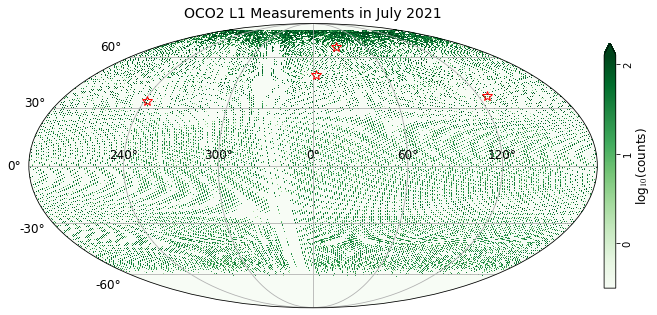

In [44]:
from matplotlib import cm
from healpy.newvisufunc import projview, newprojplot
# classic healpy mollweide projections plot with graticule and axis labels and vertical color bar
projview(
    np.nan_to_num(np.log10(onevispdf['count'].values),nan=-0.5,neginf=-0.5),
    
    ## Geo Conventions for Earth DAta
    coord=["G"],
    
    graticule=True,
    graticule_labels=True,
    unit=r'log$_{10}$(counts)',
    #xlabel="longitude",
    #ylabel="latitude",
    min=-0.5,
    max=2.1,
    cbar_ticks=[0,1,2],
    cb_orientation="vertical",
    projection_type="mollweide",
    cmap=cm.Greens,
    nest=True,
    
    ## Geo Conventions for Earth Data
    flip="geo",
    phi_convention="clockwise",
    
    override_plot_properties={"cbar_label_pad": 1.},
    title='OCO2 L1 Measurements in July 2021'
)
for i in range(numtccon):
    newprojplot(theta=tccontheta[i], phi=tcconphi[i], marker="*", \
                color="red", markersize=10, mfc='none',alpha=1.0);
plt.savefig('oco2-L1-measurements-nside1024-july-2021.pdf')
plt.show()

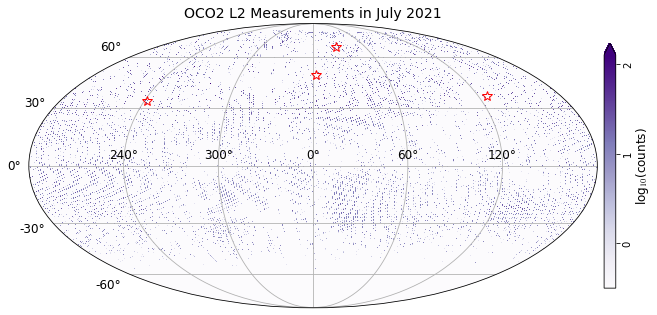

In [45]:
from matplotlib import cm
from healpy.newvisufunc import projview, newprojplot
# classic healpy mollweide projections plot with graticule and axis labels and vertical color bar
projview(
    np.nan_to_num(np.log10(twovispdf['count'].values),nan=-0.5,neginf=-0.5),
    
    ## Geo Conventions for Earth DAta
    coord=["G"],
    
    graticule=True,
    graticule_labels=True,
    unit=r'log$_{10}$(counts)',
    #xlabel="longitude",
    #ylabel="latitude",
    min=-0.5,
    max=2.1,
    cbar_ticks=[0,1,2],
    cb_orientation="vertical",
    projection_type="mollweide",
    cmap=cm.Purples,
    nest=True,
    
    ## Geo Conventions for Earth Data
    flip="geo",
    phi_convention="clockwise",
    
    override_plot_properties={"cbar_label_pad": 1.},
    title='OCO2 L2 Measurements in July 2021'
)
for i in range(numtccon):
    newprojplot(theta=tccontheta[i], phi=tcconphi[i], marker="*", \
                color="red", markersize=10, mfc='none',alpha=1.0);
plt.savefig('oco2-L2-measurements-nside1024-july-2021.pdf')
plt.show()

- The observation coverages of 28 millions L1 CO$_2$ spectra (green) and 6.5 million L2 $X_{co2}$ (orange) obtained by the oco2 satellite in July 2021. The red stars represent the locations of our selected four tcconn sites. 

In [46]:
onevispdf.to_parquet('/home/ebkim/work/oco2/data/oco2_L1_healpix_nside1024.parquet.gzip', compression='gzip')
twovispdf.to_parquet('/home/ebkim/work/oco2/data/oco2_L2_healpix_nside1024.parquet.gzip', compression='gzip')

## [4] Cross-match L1 and L2 Data at the TCCON Site in Paris

In [47]:
sitelon = tccondf[tccondf['location']=='Paris,France'].lon.values[0] 
sitelat = tccondf[tccondf['location']=='Paris,France'].lat.values[0]

In [48]:
print(sitelon,sitelat)

2.356 48.846


#### Get healpix index at the site in Paris

In [49]:
NSIDE=1024 # or 512 

In [50]:
isite = getHealPixIndexLatLon(sitelat,sitelon,NSIDE)
print(isite)

715921


#### And its 8 neighbor tiles

In [51]:
ineighbor = hp.get_all_neighbours(NSIDE,isite,nest=True).tolist()

In [52]:
iall = ineighbor+[isite]
print(iall)

[715920, 715922, 715923, 715926, 715924, 715838, 715835, 715834, 715921]


> All 9 healpix tiles, where each size is $\approx 6.3 km \times 6.3 km$ for `NSIDE=1024` (double in length for` NSIDE=512`)

### Select L1 and L2 data at the TCCON site in Paris via Healpix Index 

In [53]:
onepixdf = onedf.filter(onedf["ipx1024nested"].isin(isite))

In [54]:
twopixdf = twodf.filter(twodf["ipx1024nested"].isin(iall))

In [55]:
onepixdf.cache()

DataFrame[filename: string, channel_ind: int, pix_ind: int, row_ind: int, altitude: float, longitude: float, latitude: float, aspect: float, slope: float, sol_az: float, sol_zn: float, fo_az: float, fo_zn: float, flag: int, snr: float, continuum: float, time_str: string, spectrum: array<double>, ipx1024nested: int]

In [56]:
twopixdf.cache()

DataFrame[filename: string, altitude: float, longitude: float, latitude: float, aspect: float, slope: float, sol_az: float, sol_zn: float, xco2: float, time_str: string, ipx1024nested: int]

In [57]:
%%time
onepixdf.write.option("compression", "snappy") \
.mode("overwrite") \
.parquet('hdfs://spark00:54310/user/ebkim/data/paris_L1_isite.parquet.snappy')

CPU times: user 180 ms, sys: 177 ms, total: 358 ms
Wall time: 11min 36s


In [58]:
%%time
twopixdf.write.option("compression", "snappy") \
.mode("overwrite") \
.parquet('hdfs://spark00:54310/user/ebkim/data/paris_L2_iall.parquet.snappy')

CPU times: user 18.2 ms, sys: 37.2 ms, total: 55.4 ms
Wall time: 7.93 s


In [59]:
onepixdf.count()

3081

In [60]:
twopixdf.count()

4237

- 14985/3 = 4995 L1 spectra and 4237 L2 $X_{co2}$ at the TCCON site in Paris